In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [209]:
details_df = pd.read_csv('details.csv', index_col=0)
timestamps_df = pd.read_csv('timestamps.csv', index_col=0)

Adjusting dataset:

In [210]:
peak_df = pd.DataFrame(timestamps_df.mean(axis=1, skipna=True), columns=['avg_peak_users'])
full_df = pd.merge(details_df, peak_df, left_index=True, right_index=True) #inner join
full_df = full_df[(full_df['price'] != 0)] # drop free to play, becouse for free to play we don't have enouth dota
full_df = full_df[(full_df['ccu'] > 0)] 

full_df['total_reviews'] = full_df['positive'] + full_df['negative']
full_df['user_score'] = full_df['positive'] / full_df['total_reviews']
full_df = full_df.drop(['positive', 'negative'], axis=1)

full_df['genre'] = full_df['genre'].apply(ast.literal_eval)
full_df['languages'] = full_df['languages'].apply(ast.literal_eval)
full_df['tags'] = full_df['tags'].apply(ast.literal_eval)

Adding success_score:

In [246]:
# full_df['success_score'] = full_df['avg_peak_users'] * full_df['price']
full_df['success_score'] = full_df['ccu'] * full_df['price']

full_df = full_df.sort_values('success_score', ascending=False)
#NB! first n users will have score of 1, it is done to remove diference between first elements
full_df['success_score'] = full_df['success_score'] / full_df.iloc[10]['success_score'] 
full_df['success_score'] = full_df['success_score'].clip(0, 1)

def top(success_score):
    for i, score in enumerate(full_df['success_score']):
        if score < success_score:
            return i
    return i

Correlation:

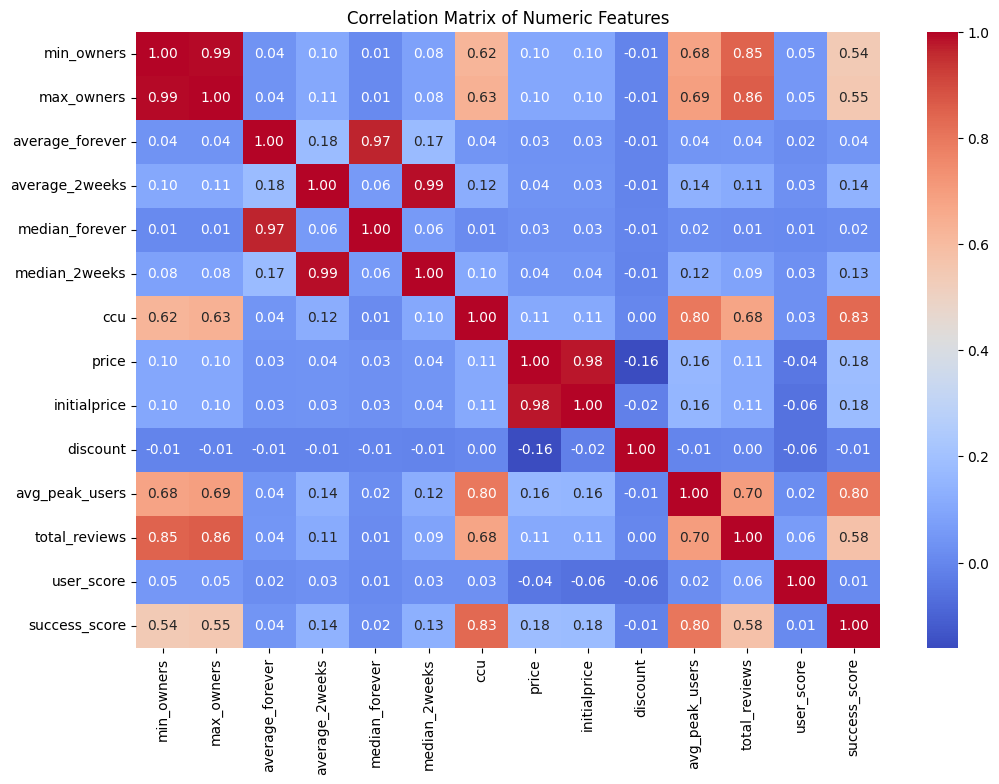

In [212]:
numeric_columns = full_df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

RandomForestClassifier by genre. RandomForestClassifier provides not accurate results, it predicts if user scolre of input genres would be above 70%, adding more data (as, price, genre and ) to input will produce more noise at output.

In [323]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score

test_df = full_df.copy()
test_df = test_df.dropna(subset=['user_score'])

unique_genres = set()
for genres in test_df['genre']:
    unique_genres.update(genres)


unique_genres_list = list(unique_genres)

mlb = MultiLabelBinarizer(classes=unique_genres_list)
genre_labels = mlb.fit_transform(test_df['genre'])

X = genre_labels
y = test_df['user_score'].apply(lambda s: s > 0.70)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

rf_classifier = RandomForestClassifier(criterion='gini',random_state=42)
rf_classifier.fit(X_train, y_train)

predictions = rf_classifier.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, predictions)}")

Accuracy: 0.8114419147694104


Simmilar model with RandomForestRegressor, which includes all important input data, due to large input it is also very unaccurate.

In [298]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


mlb_genre = MultiLabelBinarizer()
genre_encoded = mlb_genre.fit_transform(full_df['genre'])#.apply(lambda v: v[:3]))
genre_df = pd.DataFrame(genre_encoded, columns=mlb_genre.classes_, index=full_df.index)

mlb_tags = MultiLabelBinarizer()
tags_encoded = mlb_tags.fit_transform(full_df['tags'])#.apply(lambda v: v[:3]))
tags_df = pd.DataFrame(tags_encoded, columns=mlb_tags.classes_, index=full_df.index)

mlb_languages = MultiLabelBinarizer()
languages_encoded = mlb_languages.fit_transform(full_df['languages'])#.apply(lambda v: v[:3]))
languages_df = pd.DataFrame(languages_encoded, columns=mlb_languages.classes_, index=full_df.index)

test_df = full_df[['price']].copy()
test_df['languages'] = full_df['languages'].apply(lambda v: len(v))
test_df['tags'] = full_df['tags'].apply(lambda v: len(v))
test_df['genre'] = full_df['genre'].apply(lambda v: len(v))


features = pd.concat([test_df, genre_df, tags_df, languages_df], axis=1)
target = full_df['success_score'] 

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

rfr_model = RandomForestRegressor()
rfr_model.fit(X_train, y_train)



predictions = rfr_model.predict(X_test)
print(f"R-squared score: {r2_score(y_test, predictions)}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, predictions)}")

R-squared score: 0.16289789934897847
Mean Squared Error (MSE): 0.0014459188876748419


Using this model to predict success_score:

In [324]:
def predict_success_score(price, genres, tags, languages):

    genre_encoded = mlb_genre.transform([genres])
    tags_encoded = mlb_tags.transform([tags])
    languages_encoded = mlb_languages.transform([languages])

    base_df = pd.DataFrame([[price, len(languages), len(tags), len(genres)]], columns=['price', 'languages', 'tags', 'genre'])
    genre_df = pd.DataFrame(genre_encoded, columns=mlb_genre.classes_)
    tags_df = pd.DataFrame(tags_encoded, columns=mlb_tags.classes_)
    languages_df = pd.DataFrame(languages_encoded, columns=mlb_languages.classes_)
    
    features = pd.concat([base_df, genre_df, tags_df, languages_df], axis=1)

    prediction = rfr_model.predict(features)
    
    return prediction[0], top(score)


# print(mlb_genre.classes_) #all existing genres
# print(mlb_tags.classes_) #all tags genres
# print(mlb_languages.classes_) #all languages genres

score, top = predict_success_score(5999, 
            ['Adventure', 'RPG', 'Strategy'],
            ['RPG', 'Choices Matter', 'Character Customization', 'Story Rich', 'Turn-Based Combat', 'Dungeons & Dragons', 'Adventure', 'CRPG', 'Online Co-Op', 'Fantasy', 'Multiplayer', 'Romance', 'Strategy', 'Co-op Campaign', 'Singleplayer', 'Class-Based', 'Dark Fantasy', 'Combat', 'Controller', 'Stealth'],
            ['English', 'French', 'German', 'Spanish - Spain', 'Polish', 'Russian', 'Simplified Chinese', 'Turkish', 'Portuguese - Brazil', 'Italian', 'Spanish - Latin America', 'Traditional Chinese', 'Ukrainian', 'Korean'])

print(f"score: {score}, top: {top}")

score: 0.1334170237176397, top: 84


Using tenserfow for predicting ccu:

In [391]:
# from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [446]:
mlb_genre = MultiLabelBinarizer()
genre_encoded = mlb_genre.fit_transform(full_df['genre'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb_genre.classes_, index=full_df.index)

mlb_tags = MultiLabelBinarizer()
tags_encoded = mlb_tags.fit_transform(full_df['tags'])
tags_df = pd.DataFrame(tags_encoded, columns=mlb_tags.classes_, index=full_df.index)

mlb_languages = MultiLabelBinarizer()
languages_encoded = mlb_languages.fit_transform(full_df['languages'])
languages_df = pd.DataFrame(languages_encoded, columns=mlb_languages.classes_, index=full_df.index)

test_df = full_df[['price']].copy()
test_df['languages'] = full_df['languages'].apply(lambda v: len(v))
test_df['tags'] = full_df['tags'].apply(lambda v: len(v))
test_df['genre'] = full_df['genre'].apply(lambda v: len(v))

scaler = StandardScaler()
scaled_test_df = scaler.fit_transform(test_df)

X = pd.concat([test_df, genre_df, tags_df, languages_df], axis=1)
y = full_df['ccu'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



def create_model(neurons=128, optimizer='adam'):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(X.shape[1],)),
        Dense(neurons // 2, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])
    return model



model = create_model(neurons=64)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


predictions = model.predict(X_test)

Epoch 1/100
344/344 [==============================] - 1s 2ms/step - loss: 6892159.0000 - mse: 6892159.0000 - mae: 432.0882 - val_loss: 24849696.0000 - val_mse: 24849696.0000 - val_mae: 517.8577
Epoch 2/100
344/344 [==============================] - 0s 1ms/step - loss: 6883511.0000 - mse: 6883511.0000 - mae: 436.0217 - val_loss: 24824770.0000 - val_mse: 24824770.0000 - val_mae: 593.4706
Epoch 3/100
344/344 [==============================] - 0s 1ms/step - loss: 6877798.5000 - mse: 6877798.5000 - mae: 447.9124 - val_loss: 24821510.0000 - val_mse: 24821510.0000 - val_mae: 599.7124
Epoch 4/100
344/344 [==============================] - 0s 1ms/step - loss: 6879085.5000 - mse: 6879085.5000 - mae: 447.3062 - val_loss: 24823642.0000 - val_mse: 24823642.0000 - val_mae: 566.8889
Epoch 5/100
344/344 [==============================] - 0s 1ms/step - loss: 6873570.0000 - mse: 6873570.0000 - mae: 447.2307 - val_loss: 24815662.0000 - val_mse: 24815662.0000 - val_mae: 598.9992
Epoch 6/100
344/344 [====

In [445]:
data = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error (MSE): {data[0]}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(data[0])}")
print(f"Mean Absolute Error (MAE): {data[2]}")

Mean Squared Error (MSE): 18538036.0
Root Mean Squared Error (RMSE): 4305.581958341984
Mean Absolute Error (MAE): 452.5764465332031


Grid search for this model:

In [451]:
param_grid = {
    'neurons': [64, 128],
    'batch_size': [20, 32, 50],
    'validation_split': [0.1, 0.2]
}

best_mse = float('inf')
best_params = None

for neurons in param_grid['neurons']:
    for batch_size in param_grid['batch_size']:
        for validation_split in param_grid['validation_split']:
            model = create_model(neurons)
            history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size,
                                validation_split=validation_split, verbose=1)
            mse = model.evaluate(X_test, y_test, verbose=0)[1]
            if mse < best_mse:
                best_mse = mse
                best_params = {
                    'neurons': neurons,
                    'batch_size': batch_size,
                    'validation_split': validation_split
                }

print(f"Best mse: {best_mse}, best params: {best_params}")

Epoch 1/50
618/618 [==============================] - 1s 1ms/step - loss: 11286397.0000 - mse: 11286397.0000 - mae: 466.3990 - val_loss: 3301391.7500 - val_mse: 3301391.7500 - val_mae: 354.9519
Epoch 2/50
618/618 [==============================] - 1s 1ms/step - loss: 11278118.0000 - mse: 11278118.0000 - mae: 474.0898 - val_loss: 3346525.5000 - val_mse: 3346525.5000 - val_mae: 480.6513
Epoch 3/50
618/618 [==============================] - 1s 1ms/step - loss: 11274880.0000 - mse: 11274880.0000 - mae: 493.0422 - val_loss: 3299266.5000 - val_mse: 3299266.5000 - val_mae: 386.1468
Epoch 4/50
618/618 [==============================] - 1s 1ms/step - loss: 11273671.0000 - mse: 11273671.0000 - mae: 480.4299 - val_loss: 3368427.5000 - val_mse: 3368427.5000 - val_mae: 516.2029
Epoch 5/50
618/618 [==============================] - 1s 1ms/step - loss: 11263117.0000 - mse: 11263119.0000 - mae: 497.0758 - val_loss: 3330123.0000 - val_mse: 3330123.0000 - val_mae: 472.6922
Epoch 6/50
618/618 [==========

Kross validation:

In [457]:
from sklearn.model_selection import KFold


k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

mse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = create_model(best_params['neurons'])
    model.fit(X_train, y_train, epochs=100, batch_size=best_params['batch_size'], validation_split=best_params['validation_split'], verbose=1)

    mse = model.evaluate(X_test, y_test, verbose=0)[1]
    mse_scores.append(mse)

average_mse = np.mean(mse_scores)
print(f"Average MSE across {k_folds}-fold cross-validation: {average_mse}")

Epoch 1/100
344/344 [==============================] - 1s 2ms/step - loss: 13123776.0000 - mse: 13123776.0000 - mae: 560.1441 - val_loss: 9944.6680 - val_mse: 9944.6680 - val_mae: 85.6877
Epoch 2/100
344/344 [==============================] - 0s 1ms/step - loss: 13087553.0000 - mse: 13087553.0000 - mae: 590.7704 - val_loss: 5213.1929 - val_mse: 5213.1929 - val_mae: 62.0057
Epoch 3/100
344/344 [==============================] - 1s 2ms/step - loss: 13101364.0000 - mse: 13101364.0000 - mae: 571.1828 - val_loss: 7086.7188 - val_mse: 7086.7188 - val_mae: 72.7553
Epoch 4/100
344/344 [==============================] - 0s 1ms/step - loss: 13088668.0000 - mse: 13088668.0000 - mae: 580.1660 - val_loss: 6663.8716 - val_mse: 6663.8716 - val_mae: 70.8538
Epoch 5/100
344/344 [==============================] - 0s 1ms/step - loss: 13082094.0000 - mse: 13082094.0000 - mae: 587.5670 - val_loss: 16314.6309 - val_mse: 16314.6309 - val_mae: 110.5261
Epoch 6/100
344/344 [==============================] - 0s